# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

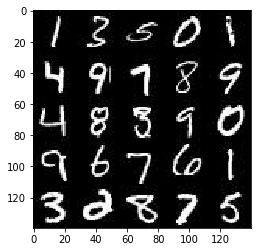

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

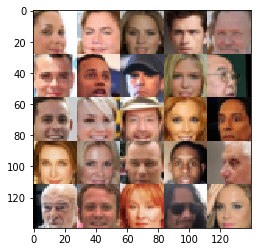

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [28]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return (inputs_images, inputs_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [48]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Creating alpha value for leaky relu
    alpha = 0.05
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        #print("Discriminator X1 shape is", x1.shape)
        x1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        #print("Discriminator X2 shape is", x2.shape)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME')
        #print("Discriminator X3 shape is", x3.shape)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 4x4x256
        
        #x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        #print("Discriminator X4 shape is", x4.shape)
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(alpha * bn4, bn4)
        # 4x4x448

        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [47]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Creating alpha value for leaky relu
    #print("Shape of Z is ", z)
    #print("Output channel dimension is", out_channel_dim)
    alpha = 0.05
    #reuse = not is_train
        
                    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        #print("Generator X1 shape is", x1.shape)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        #print("Generator X2 shape is", x2.shape)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        #print("Generator X3 shape is", x3.shape)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='SAME')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [49]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [50]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [52]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    steps, batch_number = 1,1
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    #print("Image width is", image_width)

    #print("INput variables", epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode)
    
    # 1. Build the model
                
    #print("Batch Images", batch_images.shape)
                
                
    #Invoking the model_inputs() for creating input placeholders
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
                
    #Calculate the Generator and Discriminator losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    #Run Optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Fake Input to the Generator in the form of random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                
                # TODO: Train Model
                
                #Rescale the input images
                '''it is mentioned that the values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 
                28x28 dimensional images.However, if you’re using tanh in generator function to get logits then you have to 
                rescale the images to be between -1 and 1 as mentioned in GAN_MNIST generator markdown cell.Therefore you need
                to rescale the batch_images to (-1,1). You can include the below line of code in the train function to 
                convert the range from [-0.5, 0.5] to [-1, 1]'''
                
                batch_images = batch_images*2


           
                #Executing the graph
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                    
                    
                steps += 1
 
                  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1829... Generator Loss: 2.1285
Epoch 1/2... Discriminator Loss: 0.3361... Generator Loss: 2.6877
Epoch 1/2... Discriminator Loss: 0.1345... Generator Loss: 12.7745
Epoch 1/2... Discriminator Loss: 0.0085... Generator Loss: 11.4138
Epoch 1/2... Discriminator Loss: 0.0171... Generator Loss: 5.8371
Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 4.2224
Epoch 1/2... Discriminator Loss: 0.2962... Generator Loss: 2.2834
Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 3.0025
Epoch 1/2... Discriminator Loss: 0.0944... Generator Loss: 3.0339
Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 2.5089


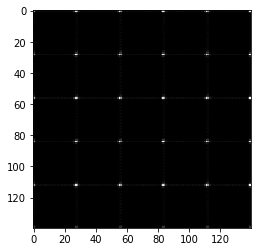

Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 1.3601
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 2.1183
Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 1.6725
Epoch 1/2... Discriminator Loss: 1.7059... Generator Loss: 0.4188
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.6584
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 1.3974
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 1.5644
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.6443
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 1.4909
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.4674


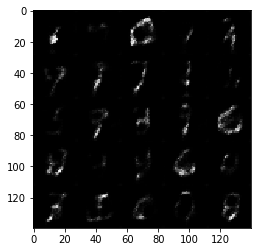

Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 1.1845
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.4300
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 0.8334
Epoch 1/2... Discriminator Loss: 1.5082... Generator Loss: 0.3498
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 1.5866... Generator Loss: 0.3323


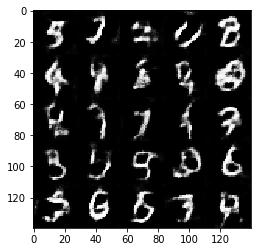

Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.3311
Epoch 1/2... Discriminator Loss: 0.9842... Generator Loss: 1.5117
Epoch 1/2... Discriminator Loss: 1.5812... Generator Loss: 0.3222
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 1.3532
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.4611
Epoch 1/2... Discriminator Loss: 0.9809... Generator Loss: 1.1092


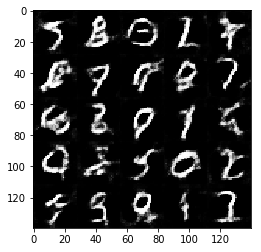

Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 2.0519
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 1.6660
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 1.0420
Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 2.1907
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 0.5459
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 0.8257... Generator Loss: 1.5068


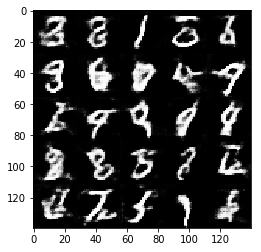

Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 0.7138
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 1.1946
Epoch 1/2... Discriminator Loss: 1.7654... Generator Loss: 0.2633
Epoch 1/2... Discriminator Loss: 1.7163... Generator Loss: 0.2967
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 0.9684
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 1.0130
Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 1.0788


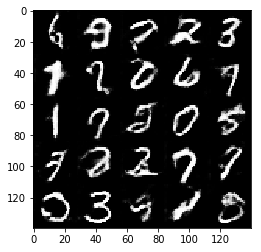

Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 0.9968... Generator Loss: 1.9255
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.2330
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 1.9216
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 0.5860
Epoch 1/2... Discriminator Loss: 1.4730... Generator Loss: 0.3505


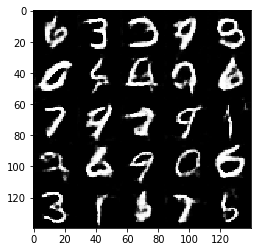

Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.3415
Epoch 1/2... Discriminator Loss: 0.8820... Generator Loss: 1.2969
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 0.9196


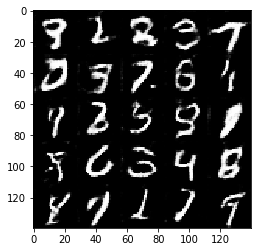

Epoch 1/2... Discriminator Loss: 1.8011... Generator Loss: 3.0661
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 1.1181
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.7153
Epoch 1/2... Discriminator Loss: 0.8909... Generator Loss: 1.7860
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.6032... Generator Loss: 0.2869
Epoch 1/2... Discriminator Loss: 1.6489... Generator Loss: 0.3397
Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 1.2181


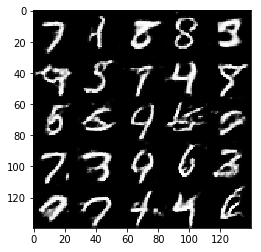

Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.4468
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.3945
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 0.6057
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.4679
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.5144
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 1.7835
Epoch 2/2... Discriminator Loss: 0.8267... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 0.9252


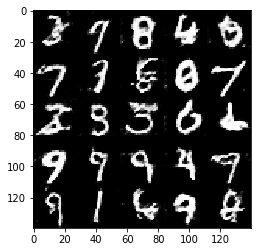

Epoch 2/2... Discriminator Loss: 2.3930... Generator Loss: 4.5893
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 0.7266
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.4809
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 1.0771... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 0.9513
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.4391
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.7481


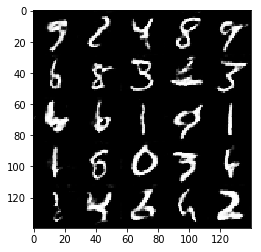

Epoch 2/2... Discriminator Loss: 0.9694... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.4815
Epoch 2/2... Discriminator Loss: 0.9067... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.7143... Generator Loss: 0.3224
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 0.7545... Generator Loss: 1.7322
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.4046
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 2.0805
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 2.4137
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 0.8971


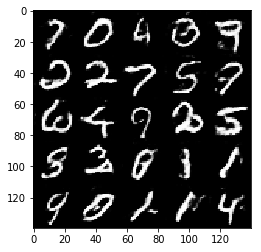

Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.3440
Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 1.3120
Epoch 2/2... Discriminator Loss: 1.9710... Generator Loss: 0.2353
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 0.6722... Generator Loss: 1.5335
Epoch 2/2... Discriminator Loss: 2.2330... Generator Loss: 0.1857
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 0.7662
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 1.7886


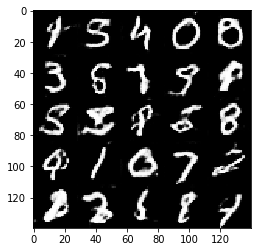

Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.0255
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 2.0244
Epoch 2/2... Discriminator Loss: 0.7536... Generator Loss: 1.2848
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 1.9401... Generator Loss: 2.9490
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.7398
Epoch 2/2... Discriminator Loss: 0.7048... Generator Loss: 1.1056


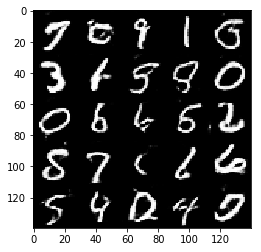

Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 0.9326
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.9428... Generator Loss: 0.2874
Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 0.8729
Epoch 2/2... Discriminator Loss: 1.6661... Generator Loss: 0.3551
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 0.8980


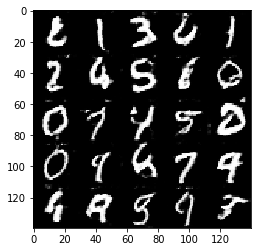

Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 0.5497
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 0.9821
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 1.5857... Generator Loss: 0.4380
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 1.7556
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.8359
Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 1.3386
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.5879


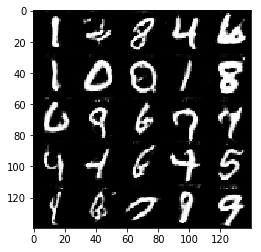

Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 1.4199
Epoch 2/2... Discriminator Loss: 0.7413... Generator Loss: 1.0029
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.1139
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.4277
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 1.9108
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 0.3738
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.4062
Epoch 2/2... Discriminator Loss: 1.6394... Generator Loss: 0.2939
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.0970


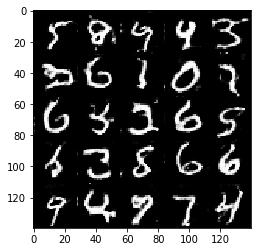

Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.4346
Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 1.3473
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.5667
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.4143
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.7304
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 0.9763
Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 1.0561
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.6468
Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 1.2986


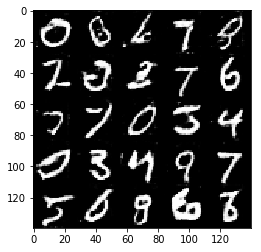

Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.9558
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.1123
Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 1.7326
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.0909
Epoch 2/2... Discriminator Loss: 0.6224... Generator Loss: 1.4095
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 0.5269... Generator Loss: 2.0739


In [53]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1444... Generator Loss: 10.0258
Epoch 1/1... Discriminator Loss: 0.2430... Generator Loss: 2.5401
Epoch 1/1... Discriminator Loss: 2.3114... Generator Loss: 13.5058
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 3.8894
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 2.0267
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 2.8458
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 0.2590... Generator Loss: 2.5626
Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 2.8051
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 1.5663


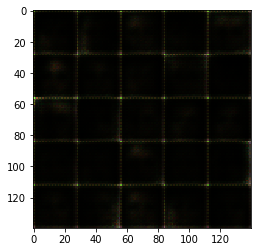

Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 2.3355
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.8367... Generator Loss: 11.2217
Epoch 1/1... Discriminator Loss: 0.1744... Generator Loss: 4.3845
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 2.4898
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 2.0175
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7972


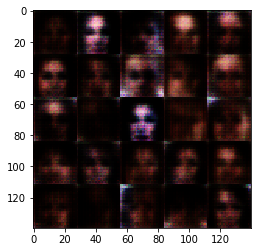

Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 3.3420
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.3991
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.9932... Generator Loss: 0.2221
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 1.6865
Epoch 1/1... Discriminator Loss: 3.2937... Generator Loss: 4.7442
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.1660


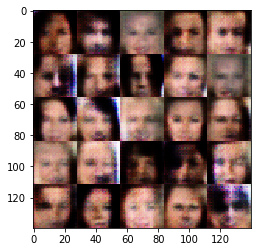

Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 1.8800
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.3614
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 2.3197
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 2.2781
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.7849


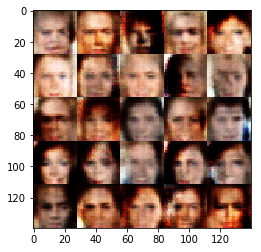

Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 4.5435
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 2.3353
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 2.8607
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.9288


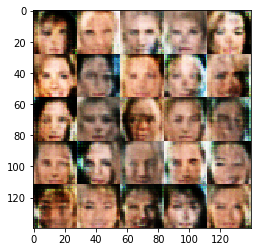

Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 2.6824
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 2.3151
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 1.0096


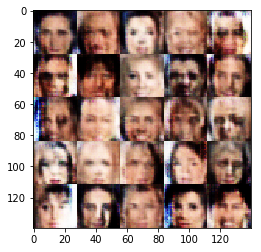

Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 2.6806
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 1.5751
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 2.0933


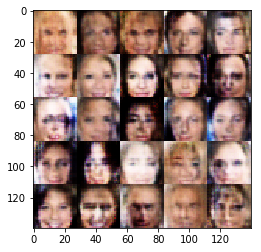

Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.1210
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.3421
Epoch 1/1... Discriminator Loss: 2.5021... Generator Loss: 0.1221
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.2126


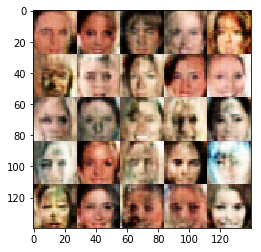

Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.8913... Generator Loss: 2.8951
Epoch 1/1... Discriminator Loss: 1.9857... Generator Loss: 0.1946
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.2385
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.5706
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 2.1417
Epoch 1/1... Discriminator Loss: 1.5963... Generator Loss: 0.4293


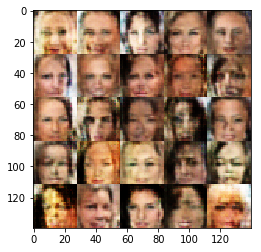

Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.3161
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 1.6331
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.8506
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.6856


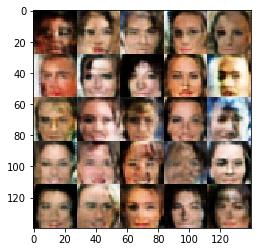

Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.3148
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.3110
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 2.0303
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.1604


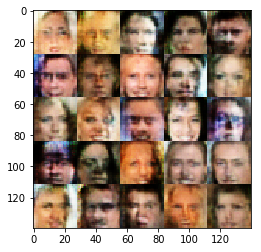

Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.2950
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 1.6240
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6290


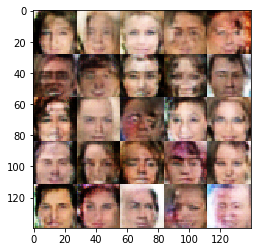

Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.6980
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.3137
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.4061
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.7483


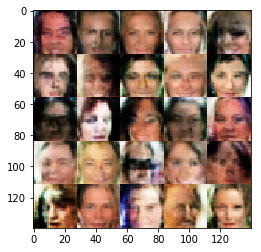

Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 2.4479
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 0.2969
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.3866


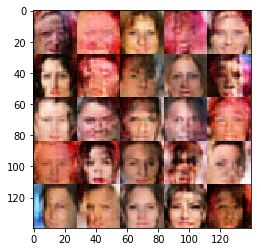

Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.5370
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.0495


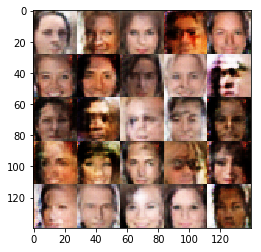

Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.0554


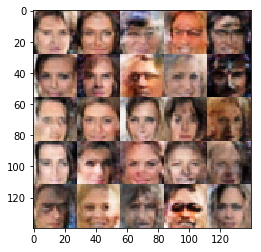

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.7769
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.4274
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.8198


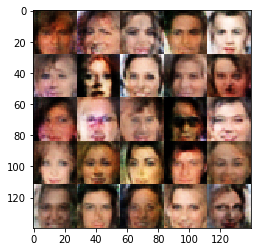

Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.4850
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.2978
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.9915


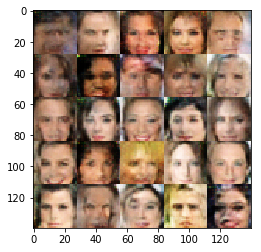

Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.2319
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.0897


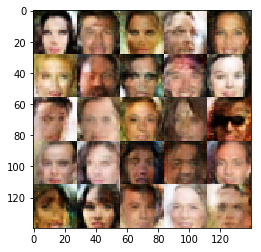

Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.4282


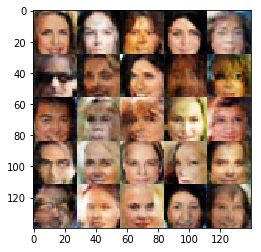

Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.3240
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.3240
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.1186
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.5593


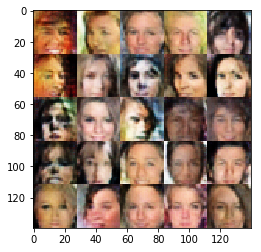

Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 0.2717
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9999


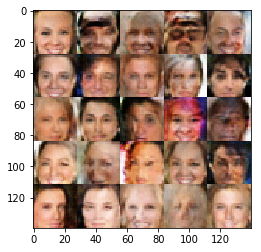

Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.3174
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.6891


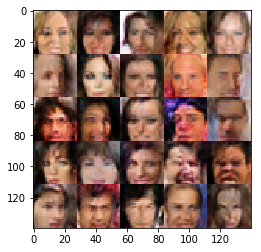

Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.0147


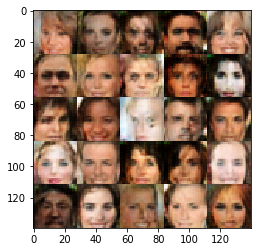

Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.7289... Generator Loss: 0.2582
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5102


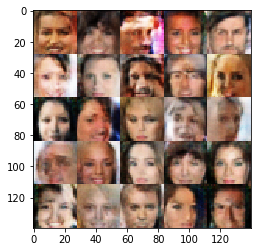

Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.8311


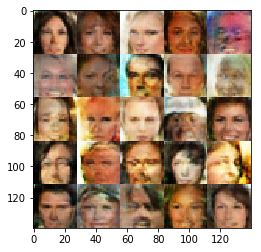

Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.3132
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 3.0947... Generator Loss: 0.0779
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7700


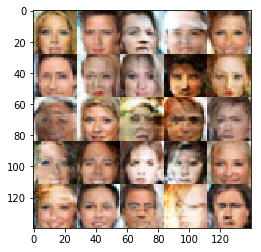

Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.3947
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.6782


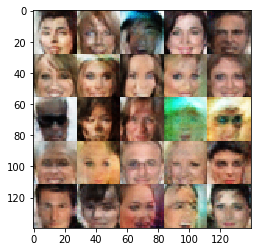

Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.3231


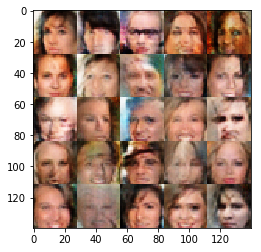

Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.3986
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.0343


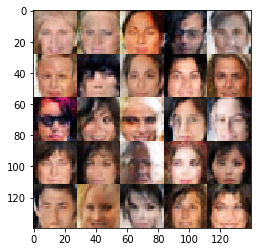

Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.8441... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.8070


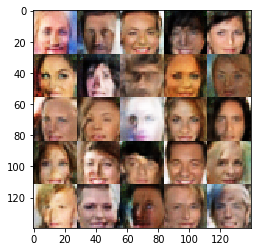

Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.6922


In [55]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.